In [4]:
import urllib.request
from bs4 import BeautifulSoup

from nltk.corpus import stopwords
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.corpus import reuters
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

from gensim.summarization import summarize
from gensim.summarization import keywords

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# Get S-1

In [5]:
def get_by_url(url):
    response = urllib.request.urlopen(url)
    html = response.read()
    soup = BeautifulSoup(html,"html5lib")
    text = soup.get_text(strip=True)
    return text

In [6]:
ipo = {
    'DBX' : get_by_url('https://www.sec.gov/Archives/edgar/data/1467623/000119312518055809/d451946ds1.htm'),
    'SPOT' : get_by_url('https://www.sec.gov/Archives/edgar/data/1639920/000119312518063434/d494294df1.htm')
}

In [88]:
ipo = {
    'DBX' : sent_tokenize(get_by_url('https://www.sec.gov/Archives/edgar/data/1467623/000119312518055809/d451946ds1.htm')),
    'SPOT' : sent_tokenize(get_by_url('https://www.sec.gov/Archives/edgar/data/1639920/000119312518063434/d494294df1.htm'))
}

In [4]:
ipo = {
    'DBX' : open('/Users/Void/git/IPOMiner/Data/DBX.txt', 'rb').read().decode("UTF-8"),
    'SPOT' : open('/Users/Void/git/IPOMiner/Data/SPOT.txt', 'rb').read().decode("UTF-8")
}

In [7]:
print(len(ipo['DBX']), len(ipo['SPOT']))

714181 851732


In [12]:
with open("/Users/Void/git/IPOMiner/Data/SPOT.txt", "w", encoding="utf-8") as f:
    f.write(ipo['SPOT'])

In [5]:
ipo['DBX']

'S-11d451946ds1.htmS-1S-1Table of ContentsAs filed with the Securities and Exchange Commission on February 23, 2018Registration No.\xa0333-UNITED STATESSECURITIES AND EXCHANGE COMMISSIONWashington, D.C. 20549FORMS-1REGISTRATION STATEMENTUnderThe\nSecurities Act of 1933Dropbox, Inc.(Exact name\nof Registrant as specified in its charter)Delaware737226-0138832(State or other jurisdiction ofincorporation or organization)(Primary Standard IndustrialClassification Code Number)(I.R.S. EmployerIdentification Number)Dropbox, Inc.333 Brannan\nStreetSan Francisco, California 94107(415) 857-6800(Address,\nincluding zip code, and telephone number, including area code, of Registrant’s principal executive offices)Andrew W.\nHoustonChief Executive OfficerDropbox, Inc.333 Brannan\nStreetSan Francisco, California 94107(415) 857-6800(Name,\naddress, including zip code, and telephone number, including area code, of agent for service)Copies to:Tony Jeffries, Esq.Rezwan D. Pavri, Esq.Lisa\nL. Stimmell, Esq.

# Sentiment Analysis

In [94]:
def get_sentiment_df(symbol):
    sid = SentimentIntensityAnalyzer()
    ps_list = []

    for sentence in ipo[symbol]:
        ps = sid.polarity_scores(sentence)
        ps['sent'] = sentence
        ps_list.append(ps)
    
    df = pd.DataFrame(ps_list)

    return df

In [95]:
df_dbx = get_sentiment_df('DBX')
df_spot = get_sentiment_df('SPOT')

In [121]:
df_dbx.head(3)

,compound,neg,neu,pos,sent
0,0.0000,0.126,0.747,0.126,S-11d451946ds1.htmS-1S-1Table of ContentsAs fi...
1,0.2960,0.000,0.932,0.068,333-UNITED STATESSECURITIES AND EXCHANGE COMMI...
2,0.4767,0.013,0.941,0.046,"EmployerIdentification Number)Dropbox, Inc.333..."


In [122]:
df_dbx[(df_dbx['neg'] > df_dbx['neg'].quantile(0.8)) | (df_dbx['pos'] > df_dbx['pos'].quantile(0.8))]

,compound,neg,neu,pos,sent
0,0.0000,0.126,0.747,0.126,S-11d451946ds1.htmS-1S-1Table of ContentsAs fi...
3,0.8834,0.000,0.736,0.264,☐If this Form is filed to register additional ...
4,0.7783,0.000,0.789,0.211,☐If this Form is a post-effective amendment fi...
5,0.7783,0.000,0.789,0.211,☐If\nthis Form is a post-effective amendment f...
10,0.7579,0.000,0.681,0.319,These securities may not be sold until the reg...
16,0.6705,0.000,0.606,0.394,Each share of Class A common stock is entitled...
17,0.7717,0.000,0.717,0.283,Each share of\nClass B common stock is entitle...
18,0.8126,0.043,0.748,0.209,Shares of Class C common stock have no voting ...
19,0.8402,0.051,0.714,0.235,"Following this offering, outstanding shares of..."
22,0.9201,0.000,0.813,0.187,"As such, in this registration statement we hav..."


In [101]:
df_dbx.mean()

compound    0.327937
neg         0.026576
neu         0.866719
pos         0.106704
dtype: float64

In [102]:
df_spot.mean()

compound    0.322624
neg         0.030375
neu         0.859371
pos         0.110252
dtype: float64

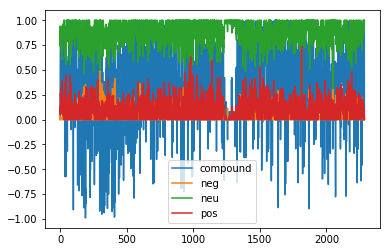

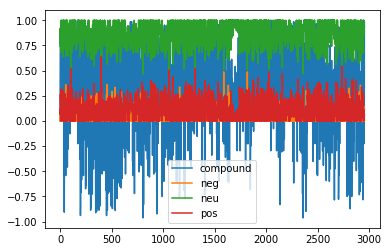

In [99]:
df_dbx.plot()
df_spot.plot()

# EDGAR

In [232]:
import edgar
from edgar import Edgar
from edgar import Company

In [233]:
symbols = list(pd.read_html('https://www.nasdaq.com/markets/ipos/activity.aspx?tab=pricings&month=2018-03')[0]['Symbol'].values[:3])

In [234]:
def get_symbols_df():
    # load symbol lists
    nasdaq = pd.read_csv('http://www.nasdaq.com/screening/companies-by-name.aspx?letter=0&exchange=nasdaq&render=download')
    nyse = pd.read_csv('http://www.nasdaq.com/screening/companies-by-name.aspx?letter=0&exchange=nyse&render=download')
    amex = pd.read_csv('http://www.nasdaq.com/screening/companies-by-name.aspx?letter=0&exchange=amex&render=download')
    etf = pd.read_csv('http://www.nasdaq.com/investing/etfs/etf-finder-results.aspx?download=Yes')
    arca = pd.read_excel('https://www.nyse.com/publicdocs/nyse/markets/nyse-arca/NYSE_Arca_Eligible_Securities.xlsx')
    arca.rename(columns={'Security Description' : 'Name', 'Symbol ' : 'Symbol'}, inplace=True)
    us = nasdaq.append(nyse).append(amex).append(etf).append(arca)

    # create symbols df
    df_symbols = us.copy()

    # keep unique assets
    df_symbols = df_symbols.drop_duplicates(subset=['Symbol'])

    # replace uknown sectors
    df_symbols['Sector'].fillna('Other', inplace=True)
    df_symbols.Sector.replace(['n/a'], ['Other'], inplace=True)

    # assign index
    df_symbols.set_index('Symbol', inplace=True)
    df_symbols.sort_index(level=[0], inplace=True)

    # keep only relevant cols
    df_symbols = df_symbols[['Name', 'Sector', 'industry']]

    print('symbols', df_symbols.shape)
    
    return df_symbols

In [235]:
df_symbols = get_symbols_df()

symbols (8800, 3)


In [236]:
df_symbols = df_symbols.loc[symbols]

In [237]:
ipo = {}

for x in df_symbols.index:
    print(x)
    
    #create company
    tmpEdgar = Edgar()
    possible_companies = tmpEdgar.findCompanyName(df_symbols.loc[x]['Name'])
    print('possible_companies:', possible_companies)
    
    #validate
    if len(possible_companies) == 0:
        print('no possible companies:', x)
        continue
    elif len(possible_companies) > 1:
        print('too many possible companies:', x)
        continue
    
    name = possible_companies[0]
    cik = tmpEdgar.getCikByCompanyName(possible_companies[0])
    company = Company(name, cik)
    
    #look for S-1
    print(company.getFilingsUrl(filingType = "S-1"))
    tree = company.getAllFilings(filingType = "S-1")
    docs = edgar.getDocuments(tree, noOfDocuments=5)
    
    ipo[x] = docs

GNPX
possible_companies: ['GENPREX, INC.']
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0001595248&type=S-1&dateb=&owner=include&count=100
IQ
possible_companies: ['IQIYI, INC.']
https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0001722608&type=S-1&dateb=&owner=include&count=100
UMRX
possible_companies: ['UNUM THERAPEUTICS INC.', 'UNUM THERAPEUTICS, INC.']
too many possible companies: UMRX


# Summarization

In [9]:
import requests

#text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text
text = requests.get('https://www.sec.gov/Archives/edgar/data/1639920/000119312518063434/d494294df1.htm').text

print('Summary:')
print(summarize(text, ratio=0.01))

print('\nKeywords:')
print(keywords(text, ratio=0.01))

Summary:
In addition, we have issued ten beneficiary certificates per ordinary share held of record (excluding warrants, options, and RSUs, as applicable) to entities beneficially owned by our founders, Daniel Ek and Martin
Based on information available to us, the low and high sales price per ordinary share for such private transactions during the year ended December&nbsp;31, 2017 was $37.50 and $125.00, respectively, and during the period from January&nbsp;1, 2018
</P> <P STYLE="margin-top:6pt; margin-bottom:0pt; text-indent:4%; font-size:10pt; font-family:Times New Roman">Based on information provided by the NYSE, the opening public price of our ordinary shares on the
Based on such orders, the designated market maker will determine an opening price for our ordinary shares in consultation with a financial advisor pursuant to
securities, long term investment, Convertible Notes (as defined herein), and derivative financial instruments, which have been measured at fair value.
<P STYLE="

roman
including
include
included
includes
nbsp
font
users
user
certain
tax
taxes
taxing
taxed
shares
share
shared
sharing
company
companies
market
marketing
markets
marketers
marketability
musical
music
new
news
additional
addition
additions
provided
provide
providers
provides
providing
provider
spotify
advertising
advertisers
advertisements
advertisement
advertiser
data
service
services
serviced
generate
general
generated
generally
generating
generates
contents
content
based
base
bases
required
requires
requirements
require
requiring
requirement
rates
rate
rating
group
groups
grouped
financial
business
businesses


In [125]:
print(keywords(ipo['DBX'], ratio=0.01))

TypeError: decoding to str: need a bytes-like object, list found

# Read PDF

In [1]:
import PyPDF2 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [3]:
#write a for-loop to open many files -- leave a comment if you'd #like to learn how
filename = '/Users/Void/git/IPOMiner/Data/DBX.pdf' 
#open allows you to read the file
pdfFileObj = open(filename,'rb')
#The pdfReader variable is a readable object that will be parsed
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
#discerning the number of pages will allow us to parse through all #the pages
num_pages = pdfReader.numPages
count = 0
text = ""
#The while loop will read each page
while count < num_pages:
    pageObj = pdfReader.getPage(count)
    count +=1
    text += pageObj.extractText()

In [4]:
text

''